In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Rescaling
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model, image_dataset_from_directory

In [3]:
from tensorflow.keras.losses import binary_crossentropy
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
import locale
locale.getpreferredencoding = lambda: "UTF-8"

Mounted at /content/gdrive


In [5]:
!mkdir /root/.kaggle

In [6]:
!scp '/content/gdrive/My Drive/DeepLearning-Class/kaggle.json' /root/.kaggle/

In [7]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

100% 785M/788M [00:38<00:00, 23.4MB/s]
100% 788M/788M [00:38<00:00, 21.6MB/s]


In [8]:
!unzip microsoft-catsvsdogs-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/550.jpg   
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  

In [9]:
image_dir = "PetImages"
SEED = 42
img_height = 224
img_width = 224

In [10]:
## Checking All files are valid images
invalid_cat = []
invalid_dog = []
for img in os.listdir("PetImages/Cat"):
    image_string = tf.io.read_file("PetImages/Cat/"+img)
    try:
        # Decode the image file
        if img.lower().endswith('jpg'):
            image = tf.image.decode_jpeg(image_string, channels=3)
        elif img.lower().endswith('png'):
            image = tf.image.decode_png(image_string, channels=3)
    except tf.errors.InvalidArgumentError as e:
        invalid_cat.append(img)
for img in os.listdir("PetImages/Dog"):
    image_string = tf.io.read_file("PetImages/Dog/"+img)
    try:
        # Decode the image file
        if img.lower().endswith('jpg'):
            image = tf.image.decode_jpeg(image_string, channels=3)
        elif img.lower().endswith('png'):
            image = tf.image.decode_png(image_string, channels=3)
    except tf.errors.InvalidArgumentError as e:
        invalid_dog.append(img)

In [11]:
for cat in invalid_cat:
    os.remove("PetImages/Cat/"+cat)
for dog in invalid_dog:
    os.remove("PetImages/Dog/"+dog)

In [12]:
train_cd = image_dataset_from_directory(image_dir,
                                       validation_split=0.2,
                                       subset='training',
                                       seed=SEED,
                                       image_size=(img_height, img_width))

Found 24824 files belonging to 2 classes.
Using 19860 files for training.


In [13]:
test_cd = image_dataset_from_directory(image_dir,
                                       validation_split=0.2,
                                       subset='validation',
                                       seed=SEED,
                                       image_size=(img_height, img_width))

Found 24824 files belonging to 2 classes.
Using 4964 files for validation.


In [14]:
vgg_model = VGG16(weights='imagenet', include_top=True, input_shape=(img_height, img_width,3))

553467096/553467096 [==============================] - 25s 0us/step


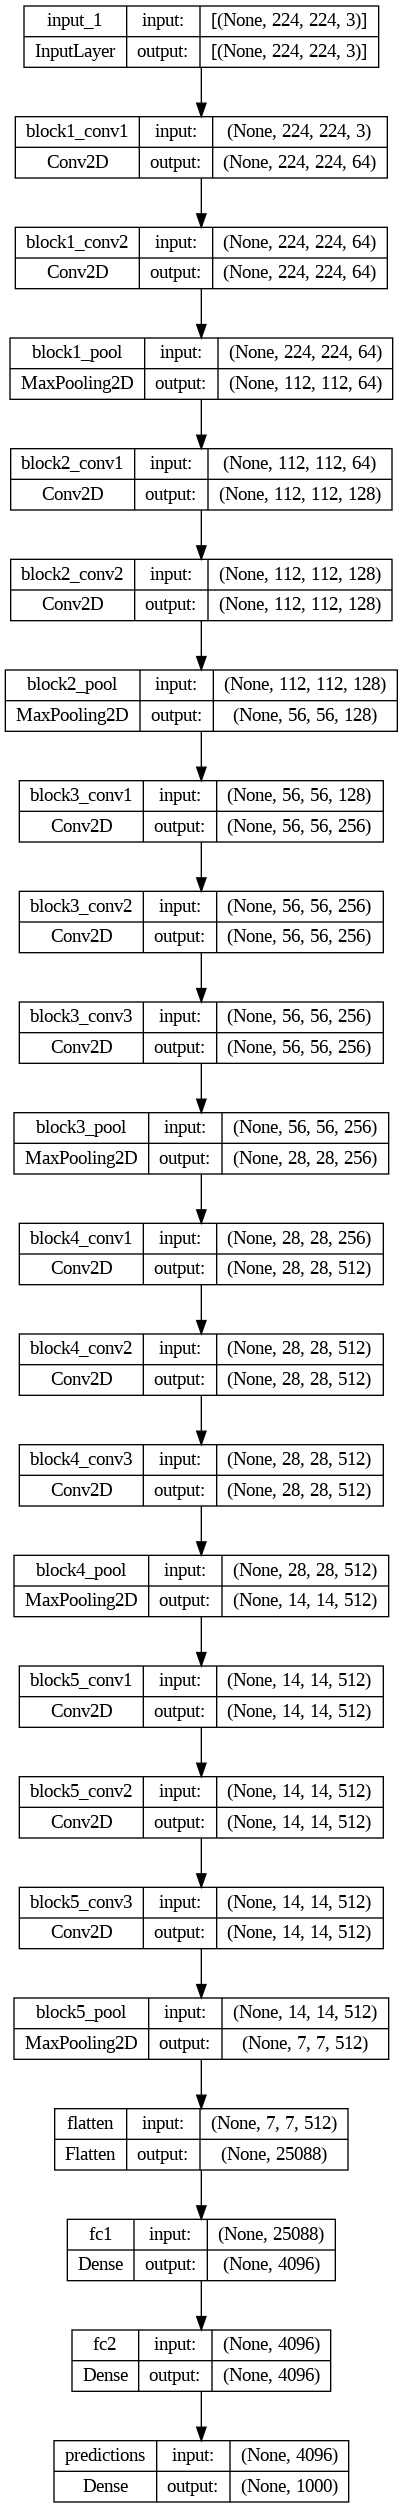

In [15]:
plot_model(vgg_model, show_shapes=True)

In [16]:
## Feature Extraction
dc_model = Sequential()
for layer in vgg_model.layers[:-1]:
  layer.trainable = False
  dc_model.add(layer)

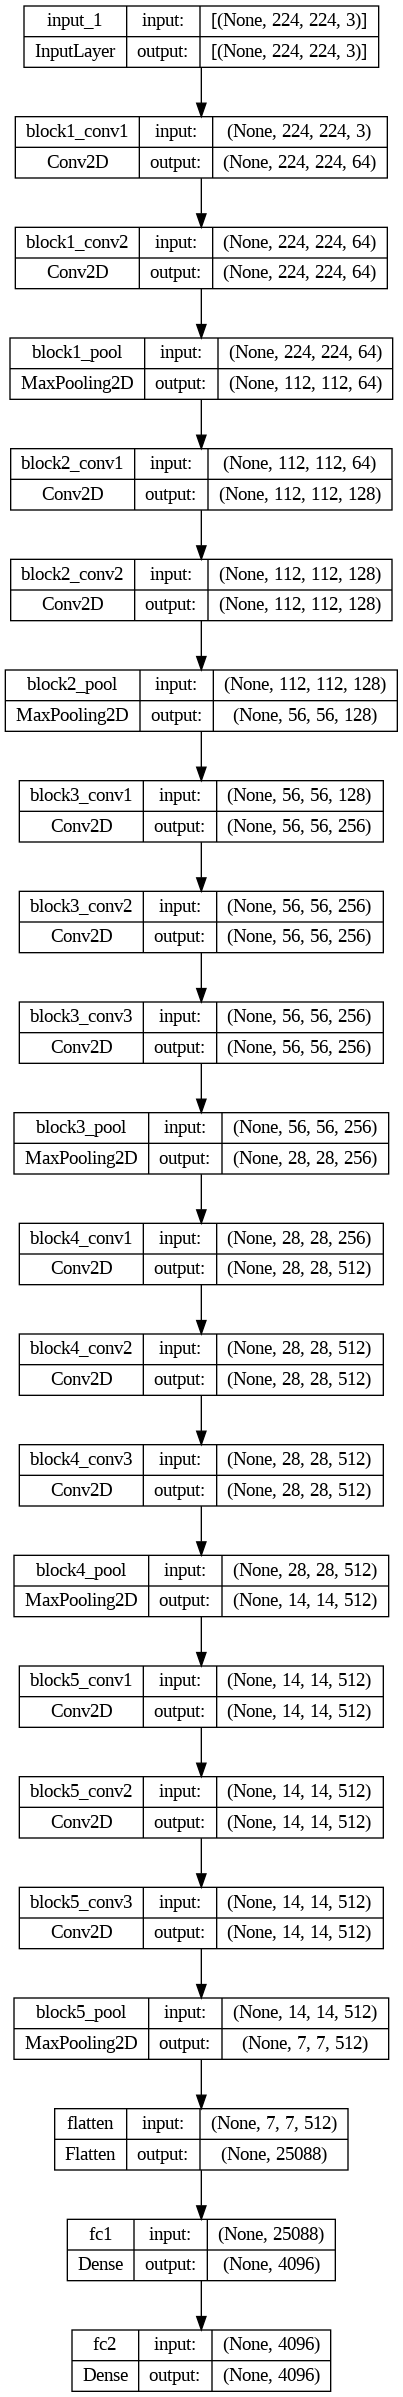

In [17]:
plot_model(dc_model, show_shapes=True)

In [18]:
dc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [19]:
dc_model.add(Dense(1, activation='sigmoid', name='output'))

In [20]:
dc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [21]:
dc_model.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy'])

In [22]:
dc_model.fit(train_cd,  epochs=2)

Epoch 1/10
621/621 [==============================] - 103s 143ms/step - loss: 0.0931 - accuracy: 0.9655
Epoch 2/10
433/621 [===================>..........] - ETA: 26s - loss: 0.0682 - accuracy: 0.9748

KeyboardInterrupt: ignored

In [23]:
dc_model.evaluate(test_cd)

156/156 [==============================] - 24s 150ms/step - loss: 0.0852 - accuracy: 0.9694


[0.08519507944583893, 0.9693795442581177]

In [41]:
vgg_model2 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256,3))

train_cd2 = image_dataset_from_directory('PetImages/', validation_split=0.3,
                                         subset = 'training',
                                         seed = SEED,
                                         image_size=(256,256))
test_cd2 = image_dataset_from_directory('PetImages/', validation_split=0.3,
                                         subset = 'validation',
                                         seed = SEED,
                                         image_size=(256,256))

Found 24824 files belonging to 2 classes.
Using 17377 files for training.
Found 24824 files belonging to 2 classes.
Using 7447 files for validation.


In [25]:
# Fine Tuning
tr_model = Sequential([Rescaling(1/255),vgg_model2])
tr_model.add(Flatten())
#tr_model.add(Dense(1000, activation='relu', kernel_initializer='random_uniform'))
#tr_model.add(Dense(10, activation='relu',  kernel_initializer='random_uniform'))
tr_model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform'))
tr_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
vgg_model2.trainable = False # To Freeze Training

In [27]:
tr_model.fit(train_cd2, epochs=1)

325/544 [================>.............] - ETA: 1:51 - loss: 0.7934 - accuracy: 0.5183

KeyboardInterrupt: ignored

In [ ]:
tr_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 32769     
                                                                 
Total params: 14747457 (56.26 MB)
Trainable params: 32769 (128.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
history = tr_model.fit(train_cd2, validation_data = test_cd2, epochs=2)

Epoch 1/2
 53/621 [=>............................] - ETA: 28s - loss: 0.6052 - accuracy: 0.7270

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 95/621 [===>..........................] - ETA: 26s - loss: 0.4590 - accuracy: 0.7980

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


181/621 [=======>......................] - ETA: 22s - loss: 0.3575 - accuracy: 0.8456

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


204/621 [========>.....................] - ETA: 20s - loss: 0.3412 - accuracy: 0.8534

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


222/621 [=========>....................] - ETA: 20s - loss: 0.3310 - accuracy: 0.8575

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/621 [===========>..................] - ETA: 18s - loss: 0.3210 - accuracy: 0.8624

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/621 [==============>...............] - ETA: 14s - loss: 0.2901 - accuracy: 0.8755

393/621 [=================>............] - ETA: 11s - loss: 0.2771 - accuracy: 0.8818

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


431/621 [===================>..........] - ETA: 9s - loss: 0.2694 - accuracy: 0.8854

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


526/621 [========================>.....] - ETA: 4s - loss: 0.2577 - accuracy: 0.8920

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


530/621 [========================>.....] - ETA: 4s - loss: 0.2569 - accuracy: 0.8924

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/621 [============================>.] - ETA: 0s - loss: 0.2474 - accuracy: 0.8969

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


621/621 [==============================] - 40s 63ms/step - loss: 0.2473 - accuracy: 0.8969 - val_loss: 0.2146 - val_accuracy: 0.9112
Epoch 2/2
 52/621 [=>............................] - ETA: 29s - loss: 0.1883 - accuracy: 0.9219

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 95/621 [===>..........................] - ETA: 27s - loss: 0.1682 - accuracy: 0.9303

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


181/621 [=======>......................] - ETA: 22s - loss: 0.1491 - accuracy: 0.9401

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


203/621 [========>.....................] - ETA: 21s - loss: 0.1440 - accuracy: 0.9421

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


221/621 [=========>....................] - ETA: 20s - loss: 0.1414 - accuracy: 0.9439

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


248/621 [==========>...................] - ETA: 19s - loss: 0.1398 - accuracy: 0.9452

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/621 [==============>...............] - ETA: 15s - loss: 0.1335 - accuracy: 0.9475

392/621 [=================>............] - ETA: 11s - loss: 0.1334 - accuracy: 0.9477

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


430/621 [===================>..........] - ETA: 9s - loss: 0.1322 - accuracy: 0.9481 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


525/621 [========================>.....] - ETA: 5s - loss: 0.1310 - accuracy: 0.9478

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


529/621 [========================>.....] - ETA: 4s - loss: 0.1311 - accuracy: 0.9477

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


621/621 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.9480

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


621/621 [==============================] - 41s 66ms/step - loss: 0.1307 - accuracy: 0.9480 - val_loss: 0.2035 - val_accuracy: 0.9194


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

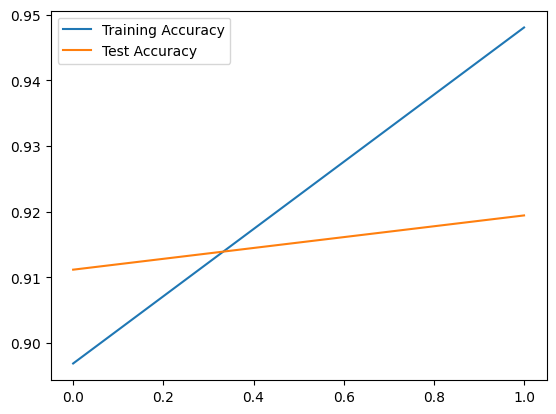

In [ ]:
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.show()

In [28]:
## Fine Tuning 2
vgg_model2.trainable = True

In [29]:
for layer in vgg_model2.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [31]:
vgg_model2.get_layer('block3_conv3').trainable

True

In [32]:
# Making the Block 5 as trainable, Rest other layers False
for layer in vgg_model2.layers:
    if layer.name.startswith('block5'):
        vgg_model2.get_layer(layer.name).trainable = True
    else:
        vgg_model2.get_layer(layer.name).trainable = False

In [43]:
vgg_model2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [34]:
from tensorflow.keras.layers import Dropout

In [44]:
# Fine Tuning
trf_model = Sequential([Rescaling(1/255), vgg_model2])
trf_model.add(Flatten())
#trf_model.add(Dense(1000, activation='relu', kernel_initializer='random_uniform'))
#trf_model.add(Dense(10, activation='relu'))
trf_model.add(Dense(1, activation='sigmoid'))
trf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

In [46]:
trf_model.fit(train_cd2, validation_data=test_cd2, epochs=1)

 81/544 [===>..........................] - ETA: 5:49 - loss: 0.6643 - accuracy: 0.6038

KeyboardInterrupt: ignored

In [ ]:
trf_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_16 (Dense)            (None, 1)                 32769     
                                                                 
Total params: 14,747,457
Trainable params: 7,112,193
Non-trainable params: 7,635,264
_________________________________________________________________


In [47]:
## Adding Layers of Own Choice
print(vgg_model2.layers)
# Lets remove Last Block
vgg_custom = vgg_model2.layers[:-4]

[<keras.src.engine.input_layer.InputLayer object at 0x78f5f8376650>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78f5f83752d0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78f6702637c0>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78f5f8377c70>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78f5f8376920>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78f670265960>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78f6701ebaf0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78f670481600>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78f670238910>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78f70b4f4be0>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78f5f8376290>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78f5f8354700>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78f5f8375390>, <keras.src.layers.convolutional.co

In [48]:
vgg_model2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [51]:
custom_model  = Sequential()
for layer in vgg_model2.layers[:-4]:
    custom_model.add(layer)

In [52]:
custom_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [53]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [54]:
trf_model = Sequential([Rescaling(1/255),custom_model])
trf_model.add(Conv2D(100, kernel_size=(3,3), activation='relu'))
trf_model.add(MaxPooling2D(pool_size=(2,2)))
trf_model.add(Flatten())
trf_model.add(Dense(100, activation='relu', kernel_initializer='random_uniform'))
#trf_model.add(Dense(10, activation='relu'))
trf_model.add(Dense(1, activation='sigmoid'))
trf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
trf_model.fit(train_cd2, validation_data = test_cd2, epochs=1)

544/544 [==============================] - 123s 221ms/step - loss: 0.6958 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4951


In [ ]:
trf_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 sequential_7 (Sequential)   (None, 16, 16, 512)       7635264   
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 100)       460900    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 100)        0         
 )                                                               
                                                                 
 flatten_7 (Flatten)         (None, 4900)              0         
                                                                 
 dense_17 (Dense)            (None, 100)               490100    
                                                      

## Tensorflow Hub Models

In [56]:
!pip install tensorflow_hub

In [57]:
import tensorflow_hub as hub

In [58]:
# Without Training Usage
hub_model = Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/classification/2",
                  input_shape = (480,480,3))
])

In [ ]:
#import import_ipynb
#from CNN import load_process, predict_decode

In [64]:
import importlib
from tensorflow.keras.preprocessing import image

In [65]:
dog = image.load_img("PetImages/Dog/10003.jpg", target_size=(480,480))

In [66]:
dog = np.array(dog)/255

In [67]:
dog.shape

(480, 480, 3)

In [68]:
hub_model.input

<KerasTensor: shape=(None, 480, 480, 3) dtype=float32 (created by layer 'keras_layer_input')>

In [69]:
dog = np.expand_dims(dog, axis=0)

In [70]:
dog.shape

(1, 480, 480, 3)

In [71]:
result = hub_model.predict(dog)

1/1 [==============================] - 3s 3s/step


In [72]:
decode_predictions(result)

35363/35363 [==============================] - 0s 0us/step


[[('n02099601', 'golden_retriever', 6.6082344),
  ('n02108551', 'Tibetan_mastiff', 6.2526684),
  ('n02112137', 'chow', 5.5308356),
  ('n02107908', 'Appenzeller', 4.6225867),
  ('n02104029', 'kuvasz', 4.4041433)]]

In [73]:
## Trainable
thub_model = Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
                   trainable=True,input_shape=(img_height, img_width,3))
])

In [74]:
trainable_model  = Sequential([
  Rescaling(1/255),
  thub_model,
  Dense(1, activation='sigmoid')
])
trainable_model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])


In [78]:
thub_model.trainable=False

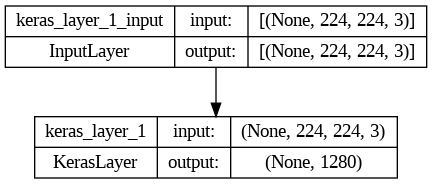

In [76]:
plot_model(thub_model, show_shapes=True)

In [79]:
trainable_model.fit(train_cd, validation_data=test_cd, epochs=1)

363/621 [================>.............] - ETA: 1:55 - loss: 0.1242 - accuracy: 0.9539

KeyboardInterrupt: ignored

In [80]:
## Flowers Dataset
!wget "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

--2023-12-06 04:46:22--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  22.7MB/s    in 11s     

2023-12-06 04:46:34 (20.1 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [82]:
!tar -xzf flower_photos.tgz

In [83]:
!ls

 flower_photos	     microsoft-catsvsdogs-dataset.zip   PetImages
 flower_photos.tgz   model.png			       'readme[1].txt'
 gdrive		    'MSR-LA - 3467.docx'	        sample_data


In [84]:
os.listdir("flower_photos")

['sunflowers', 'daisy', 'dandelion', 'roses', 'tulips', 'LICENSE.txt']

In [85]:
train_flowers = image_dataset_from_directory("flower_photos",
                                       validation_split=0.2,
                                       subset='training',
                                       seed=SEED,
                                       image_size=(img_height, img_width))

test_flowers = image_dataset_from_directory("flower_photos",
                                       validation_split=0.2,
                                       subset='validation',
                                       seed=SEED,
                                       image_size=(img_height, img_width))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [86]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Rescaling

In [87]:
trainable_model  = Sequential([
  Rescaling(1/255),
  thub_model,
  tf.keras.layers.Dense(5, activation='softmax')
])
trainable_model.compile(optimizer = 'adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


In [88]:
thub_model.trainable = False

In [89]:
trainable_model.fit(train_flowers, validation_data=test_flowers, epochs=1)

92/92 [==============================] - 38s 215ms/step - loss: 1.3300 - accuracy: 0.4918 - val_loss: 1.1289 - val_accuracy: 0.6308


In [91]:
daisy_img = os.listdir("flower_photos/daisy")[0]

In [93]:
## For Prediciting
image_v = image.load_img("flower_photos/daisy/"+daisy_img, target_size=(224, 224))

In [97]:
image_array = np.array(image_v)

In [98]:
image_array.shape

(224, 224, 3)

In [100]:
trainable_model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'rescaling_5_input')>

In [102]:
image_array = np.expand_dims(image_array,axis=0)

In [103]:
predictions = trainable_model.predict(image_array)

1/1 [==============================] - 4s 4s/step


In [104]:
predictions

array([[0.45180234, 0.3627916 , 0.0475947 , 0.11386061, 0.02395076]],
      dtype=float32)

In [105]:
train_flowers.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [106]:
np.argmax(predictions) # Index of the max value

0

In [107]:
train_flowers.class_names[np.argmax(predictions)]

'daisy'

## Dangerous Farm Insects Dataset

In [108]:
!kaggle datasets download -d tarundalal/dangerous-insects-dataset

100% 446M/447M [00:26<00:00, 18.1MB/s]
100% 447M/447M [00:26<00:00, 17.6MB/s]


In [110]:
!unzip dangerous-insects-dataset.zip

Archive:  dangerous-insects-dataset.zip
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_1.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_10.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_100.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_102.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_104.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_105.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_106.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_107.png  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_108.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_11.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_110.jpg  
  inflating: farm_insects/Africanized Honey Bees (Killer Bees)/Image_116.jpg  
  inflating: far

In [111]:
os.listdir("farm_insects")

['Africanized Honey Bees (Killer Bees)',
 'Aphids',
 'Colorado Potato Beetles',
 'Western Corn Rootworms',
 'Corn Borers',
 'Spider Mites',
 'Fruit Flies',
 'Brown Marmorated Stink Bugs',
 'Corn Earworms',
 'Fall Armyworms',
 'Tomato Hornworms',
 'Cabbage Loopers',
 'Citrus Canker',
 'Armyworms',
 'Thrips']

In [112]:
for l in os.listdir('farm_insects'):
    print(f"{l} class has {len(os.listdir('farm_insects/'+l))}")

Africanized Honey Bees (Killer Bees) class has 97
Aphids class has 88
Colorado Potato Beetles class has 112
Western Corn Rootworms class has 100
Corn Borers class has 115
Spider Mites class has 119
Fruit Flies class has 101
Brown Marmorated Stink Bugs class has 114
Corn Earworms class has 110
Fall Armyworms class has 113
Tomato Hornworms class has 109
Cabbage Loopers class has 104
Citrus Canker class has 104
Armyworms class has 96
Thrips class has 109


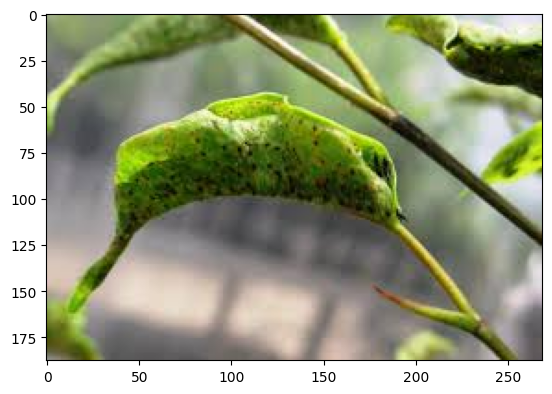

In [ ]:
plt.imshow(plt.imread("farm_insects/Thrips/Image_112.jpg"))
plt.show()

In [113]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(200,200,3))

94765736/94765736 [==============================] - 5s 0us/step


In [114]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [115]:
resnet.trainable = False

In [116]:
insect_model = Sequential()
insect_model.add(Rescaling(1/255))
insect_model.add(resnet)
insect_model.add(Flatten())
insect_model.add(Dense(100, activation='elu'))
insect_model.add(Dense(15, activation='softmax'))
insect_model.compile(optimizer = 'adam', loss=SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [117]:
train_insect = image_dataset_from_directory("farm_insects",
                                           validation_split=0.2,
                                           subset='training',
                                            seed = 99,
                                           image_size=(200,200))

Found 1591 files belonging to 15 classes.
Using 1273 files for training.


In [118]:
test_insect = image_dataset_from_directory("farm_insects",
                                           validation_split=0.2,
                                           subset='validation',
                                            seed = 99,
                                           image_size=(200,200))

Found 1591 files belonging to 15 classes.
Using 318 files for validation.


In [119]:
insect_model.fit(train_insect, validation_data=test_insect, epochs=3)

Epoch 1/3
40/40 [==============================] - 26s 445ms/step - loss: 7.8254 - accuracy: 0.0644 - val_loss: 2.8136 - val_accuracy: 0.0755
Epoch 2/3
40/40 [==============================] - 18s 392ms/step - loss: 2.7478 - accuracy: 0.0754 - val_loss: 2.7225 - val_accuracy: 0.0849
Epoch 3/3
40/40 [==============================] - 18s 394ms/step - loss: 2.7057 - accuracy: 0.0770 - val_loss: 2.7318 - val_accuracy: 0.0755


In [130]:
vgg_insect = VGG16(include_top=False,input_shape=(200,200,3))

In [120]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [121]:
tf.__version__

'2.14.0'

In [122]:
train_insect = ImageDataGenerator(rotation_range=np.random.randint(10,80),\
                                 width_shift_range=20, height_shift_range=10, \
                                 brightness_range=[0.04, 0.5],
                                 shear_range = np.random.randint(10,20),
                                 zoom_range = [0.5, 1.5],
                                 horizontal_flip = True,
                                 vertical_flip = True,
                                 rescale=1./255,
                                 validation_split=0.2)

In [123]:
test_insect = ImageDataGenerator(rescale=1/255, validation_split=0.2)

In [127]:
train_insect_g = train_insect.flow_from_directory("farm_insects", target_size=(200,200),
                                         class_mode = 'sparse',
                                                 subset = 'training',
                                                 seed = 99)

Found 1270 images belonging to 15 classes.


In [128]:
test_insect_g = test_insect.flow_from_directory("farm_insects", target_size=(200,200),
                                         class_mode = 'sparse',
                                                 subset = 'validation',
                                                 seed = 99)

Found 309 images belonging to 15 classes.


In [131]:
vgg_insect.trainable = False

In [ ]:
train_insect_g.class_indices

{'Africanized Honey Bees (Killer Bees)': 0,
 'Aphids': 1,
 'Armyworms': 2,
 'Brown Marmorated Stink Bugs': 3,
 'Cabbage Loopers': 4,
 'Citrus Canker': 5,
 'Colorado Potato Beetles': 6,
 'Corn Borers': 7,
 'Corn Earworms': 8,
 'Fall Armyworms': 9,
 'Fruit Flies': 10,
 'Spider Mites': 11,
 'Thrips': 12,
 'Tomato Hornworms': 13,
 'Western Corn Rootworms': 14}

In [129]:
insect_model.fit(train_insect_g, validation_data=test_insect_g, epochs=3)

Epoch 1/3
40/40 [==============================] - 38s 953ms/step - loss: 2.7261 - accuracy: 0.0543 - val_loss: 2.7075 - val_accuracy: 0.0712
Epoch 2/3
40/40 [==============================] - 37s 934ms/step - loss: 2.7168 - accuracy: 0.0685 - val_loss: 2.7084 - val_accuracy: 0.0712
Epoch 3/3
40/40 [==============================] - 35s 886ms/step - loss: 2.7166 - accuracy: 0.0677 - val_loss: 2.7080 - val_accuracy: 0.0744


In [132]:
insect_vggnet = Sequential([vgg_insect,
                            Flatten(),
                           Dense(100, activation='relu'),
                           Dense(15, activation='softmax')])
insect_vggnet.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [133]:
insect_vggnet.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 18432)             0         
                                                                 
 dense_9 (Dense)             (None, 100)               1843300   
                                                                 
 dense_10 (Dense)            (None, 15)                1515      
                                                                 
Total params: 16559503 (63.17 MB)
Trainable params: 1844815 (7.04 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
insect_vggnet.fit(train_insect_g, epochs=5)

Epoch 1/5
40/40 [==============================] - 22s 509ms/step - loss: 2.7660 - accuracy: 0.0701
Epoch 2/5
40/40 [==============================] - 19s 484ms/step - loss: 2.6942 - accuracy: 0.1008
Epoch 3/5
40/40 [==============================] - 19s 486ms/step - loss: 2.6851 - accuracy: 0.0945
Epoch 4/5
40/40 [==============================] - 19s 481ms/step - loss: 2.6624 - accuracy: 0.1173
Epoch 5/5
40/40 [==============================] - 19s 478ms/step - loss: 2.6301 - accuracy: 0.1260


In [ ]:
vgg_insect.layers[:-4]

In [ ]:
## Fine Tune
custom_insect = Sequential()
for layer in vgg_insect.layers[:-4]:
    custom_insect.add(layer)

In [ ]:
custom_insect.trainable = False

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
insect_custom = Sequential([custom_insect,Conv2D(10, kernel_size=(3,3), strides = (1,1), padding='same', activation='relu'),
                            MaxPooling2D(pool_size=(2,2)),
                            Flatten(),
                            Dense(100, activation='relu'),
                            Dense(15, activation='softmax')])
insect_custom.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
insect_custom.fit(train_insect_g,validation_data=test_insect_g, epochs=50)

Epoch 1/50
40/40 [==============================] - 23s 556ms/step - loss: 2.6962 - accuracy: 0.0835 - val_loss: 2.6682 - val_accuracy: 0.0939
Epoch 2/50
40/40 [==============================] - 23s 565ms/step - loss: 2.6918 - accuracy: 0.0866 - val_loss: 2.6542 - val_accuracy: 0.1068
Epoch 3/50
40/40 [==============================] - 22s 552ms/step - loss: 2.6844 - accuracy: 0.0843 - val_loss: 2.6631 - val_accuracy: 0.1036
Epoch 4/50
40/40 [==============================] - 23s 574ms/step - loss: 2.6740 - accuracy: 0.0906 - val_loss: 2.6708 - val_accuracy: 0.0939
Epoch 5/50
40/40 [==============================] - 22s 560ms/step - loss: 2.6881 - accuracy: 0.0764 - val_loss: 2.6508 - val_accuracy: 0.1003
Epoch 6/50
40/40 [==============================] - 22s 561ms/step - loss: 2.6693 - accuracy: 0.0898 - val_loss: 2.6213 - val_accuracy: 0.1003
Epoch 7/50
40/40 [==============================] - 22s 552ms/step - loss: 2.6720 - accuracy: 0.0921 - val_loss: 2.6764 - val_accuracy: 0.1230

In [ ]:
insect_custom1 = Sequential([custom_insect,
                            Flatten(),
                            #Dense(100, activation='relu'),
                            Dense(15, activation='softmax')])
insect_custom1.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
insect_custom1.fit(train_insect_g,validation_data=test_insect_g, epochs=100)

Epoch 1/100
40/40 [==============================] - 23s 576ms/step - loss: 4.1410 - accuracy: 0.2181 - val_loss: 8.0481 - val_accuracy: 0.3592
Epoch 2/100
40/40 [==============================] - 22s 561ms/step - loss: 4.1689 - accuracy: 0.2394 - val_loss: 8.9274 - val_accuracy: 0.3592
Epoch 3/100
40/40 [==============================] - 23s 567ms/step - loss: 4.3566 - accuracy: 0.2512 - val_loss: 9.5410 - val_accuracy: 0.3430
Epoch 4/100
40/40 [==============================] - 22s 560ms/step - loss: 4.2864 - accuracy: 0.2465 - val_loss: 9.0387 - val_accuracy: 0.3139
Epoch 5/100
40/40 [==============================] - 22s 560ms/step - loss: 4.0215 - accuracy: 0.2614 - val_loss: 9.2845 - val_accuracy: 0.3657
Epoch 6/100
40/40 [==============================] - 22s 561ms/step - loss: 4.2429 - accuracy: 0.2630 - val_loss: 9.9718 - val_accuracy: 0.3398
Epoch 7/100
40/40 [==============================] - 22s 564ms/step - loss: 4.1973 - accuracy: 0.2465 - val_loss: 8.9462 - val_accuracy:

KeyboardInterrupt: 

## Chest X Ray

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [ ]:
image_dataset_from_directory

In [ ]:
train_xray = image_dataset_from_directory("chest_xray/train",
                            image_size=(256,256))

Found 5216 files belonging to 2 classes.


In [ ]:
test_xray = image_dataset_from_directory("chest_xray/test",
                            image_size=(256,256))

Found 624 files belonging to 2 classes.


In [ ]:
vgg_xray = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

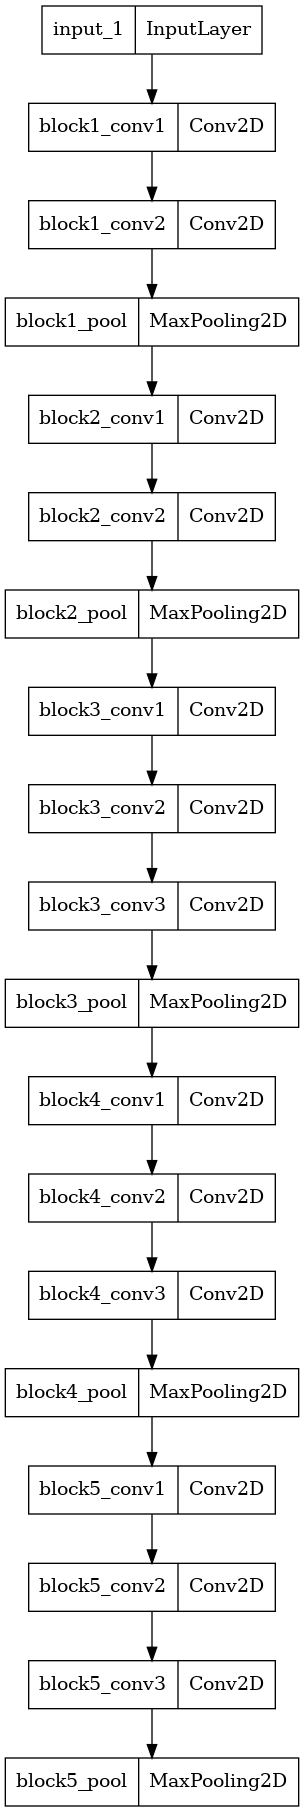

In [ ]:
plot_model(vgg_xray)

In [ ]:
vgg_xray.trainable=False

In [ ]:
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=4, verbose=1,restore_best_weights=True)

In [ ]:
xray_model = Sequential([vgg_xray,
                         Flatten(),
                         Dense(5, activation='selu', kernel_regularizer=L2(0.4)),
                         GaussianNoise(0.2),
                         Dense(1, activation='sigmoid')])
xray_model.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
xray_model.fit(train_xray, validation_data=test_xray, epochs=10, callbacks=[es])

Epoch 1/10
163/163 [==============================] - 11s 60ms/step - loss: 1.0688 - accuracy: 0.7680 - val_loss: 0.4665 - val_accuracy: 0.8894
Epoch 2/10
163/163 [==============================] - 10s 58ms/step - loss: 0.5562 - accuracy: 0.9294 - val_loss: 7.0546 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 10s 59ms/step - loss: 0.5665 - accuracy: 0.9346 - val_loss: 1.2032 - val_accuracy: 0.7740
Epoch 4/10
163/163 [==============================] - 10s 59ms/step - loss: 0.5664 - accuracy: 0.9344 - val_loss: 1.0042 - val_accuracy: 0.7772
Epoch 5/10
163/163 [==============================] - 10s 59ms/step - loss: 0.6766 - accuracy: 0.9340 - val_loss: 0.8769 - val_accuracy: 0.7981
Epoch 5: early stopping


In [ ]:
xray_model.evaluate(test_xray)

20/20 [==============================] - 1s 48ms/step - loss: 0.4665 - accuracy: 0.8894


[0.4665285646915436, 0.8894230723381042]

In [ ]:
val_xray = image_dataset_from_directory("chest_xray/val",
                            image_size=(256,256))

Found 16 files belonging to 2 classes.


In [ ]:
xray_model.evaluate(val_xray)

1/1 [==============================] - 0s 65ms/step - loss: 0.4035 - accuracy: 0.9375


[0.4034666419029236, 0.9375]

In [ ]:
## Image.
for i in os.listdir("chest_xray/val/PNEUMONIA"):
    img = image.load_img("chest_xray/val/PNEUMONIA/"+i, target_size=(256,256,3))
    img = np.expand_dims(img, axis=0)
    p = xray_model.predict(img)[0][0]
    if p>0.5:
        print("Pneumonia")
    else:
        print("Normal")

1/1 [==============================] - 0s 25ms/step
Normal
1/1 [==============================] - 0s 24ms/step
Pneumonia
1/1 [==============================] - 0s 23ms/step
Pneumonia
1/1 [==============================] - 0s 24ms/step
Pneumonia
1/1 [==============================] - 0s 24ms/step
Pneumonia
1/1 [==============================] - 0s 24ms/step
Pneumonia
1/1 [==============================] - 0s 24ms/step
Pneumonia
1/1 [==============================] - 0s 23ms/step
Pneumonia


In [ ]:
## Image.
for i in os.listdir("chest_xray/val/NORMAL"):
    img = image.load_img("chest_xray/val/NORMAL/"+i, target_size=(256,256,3))
    img = np.expand_dims(img, axis=0)
    p = xray_model.predict(img)[0][0]
    if p>0.5:
        print("Pneumonia")
    else:
        print("Normal")

1/1 [==============================] - 0s 25ms/step
Normal
1/1 [==============================] - 0s 24ms/step
Normal
1/1 [==============================] - 0s 25ms/step
Normal
1/1 [==============================] - 0s 25ms/step
Normal
1/1 [==============================] - 0s 24ms/step
Normal
1/1 [==============================] - 0s 25ms/step
Normal
1/1 [==============================] - 0s 25ms/step
Normal
1/1 [==============================] - 0s 25ms/step
Normal
